# Traditional Time Series Models for Prediction

In [188]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
import matplotlib.pyplot as plt
from hts import HTSRegressor
from tqdm import tqdm
import pickle
import os

In [189]:
df = pd.read_csv("../data/local_data/merged_cleaned_data.csv")

In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2715771 entries, 0 to 2715770
Data columns (total 11 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   Census Section           int64  
 1   District                 int64  
 2   Date                     object 
 3   Use                      object 
 4   Number of Meters         int64  
 5   Accumulated Consumption  int64  
 6   Max Temperature          float64
 7   Min Temperature          float64
 8   Precipitation            float64
 9   Tourist Accommodations   float64
 10  Hotel Overnight Stays    int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 227.9+ MB


In [191]:
# Assuming we don't wanna work by differenciating the use column
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Aggregate data by Census Section and Date. We ignore the district info since it is not relevant at all
# Another alternative would be to do the grouping by District and Date, but thus leaving to less datapoints
df_census = df.groupby(['Census Section', 'Date']).agg({
    'Accumulated Consumption': 'sum',
    'Number of Meters': 'sum',
    'Max Temperature': 'mean',
    'Min Temperature': 'mean',
    'Precipitation': 'mean',
    'Tourist Accommodations': 'mean',
    'Hotel Overnight Stays': 'mean'
}).reset_index()

df_hierarchy = df.groupby(['District', 'Census Section', 'Date']).agg({
    'Accumulated Consumption': 'sum',
    'Number of Meters': 'sum',
    'Max Temperature': 'mean',
    'Min Temperature': 'mean',
    'Precipitation': 'mean',
    'Tourist Accommodations': 'mean',
    'Hotel Overnight Stays': 'mean'
}).reset_index()

In [192]:
df_census.head()

,Census Section,Date,Accumulated Consumption,Number of Meters,Max Temperature,Min Temperature,Precipitation,Tourist Accommodations,Hotel Overnight Stays
0,801901001,2021-01-01,153414,388,7.55,4.30,5.65,1775.0,4411.0
1,801901001,2021-01-02,166201,388,8.55,1.55,0.00,4646.0,11547.0
2,801901001,2021-01-03,129309,388,9.55,0.85,0.00,3151.0,7833.0
3,801901001,2021-01-04,141909,387,10.10,0.65,0.00,4337.0,10778.0
4,801901001,2021-01-05,137782,387,9.40,0.65,0.00,4580.0,11382.0


In [193]:
df_hierarchy.head()

,District,Census Section,Date,Accumulated Consumption,Number of Meters,Max Temperature,Min Temperature,Precipitation,Tourist Accommodations,Hotel Overnight Stays
0,1,801901001,2021-01-01,153414,388,7.55,4.30,5.65,1775.0,4411.0
1,1,801901001,2021-01-02,166201,388,8.55,1.55,0.00,4646.0,11547.0
2,1,801901001,2021-01-03,129309,388,9.55,0.85,0.00,3151.0,7833.0
3,1,801901001,2021-01-04,141909,387,10.10,0.65,0.00,4337.0,10778.0
4,1,801901001,2021-01-05,137782,387,9.40,0.65,0.00,4580.0,11382.0


## SARIMA

Keep in mind that the Seasonal ARIMA is a univariate model, meaning that it cal only deal with 1 single time series; in this case, it would be the number of accumulated consumpltion. However, the model is indeed about more than 1 time series, take for instance tourist accommodations, hotel overnight stays, census section...

Moreover, different models should be trained for each census section since each census might have a different seasonality trend; the stationarity of a time series can vary significantly from one census section to another, due to different intervention effects, economic activities, or infrastructural changes over time.

Glossary: 

* Augmented Dickey-Fuller Test (ADF): Used to test for stationarity in a time series, which is a critical assumption in many time series forecasting models, including ARIMA and SARIMA models. A time series is considered stationary if its statistical properties such as mean, variance, and autocorrelation are constant over time. The test checks for the presence of a unit root in a time series model. A unit root situation implies that the time series is non-stationary, meaning it has properties that can vary over time. The ADF test addresses this by testing whether the time series can be explained without the need to account for an underlying trend or seasonality.

* H0 Null Hypothesis: In this particular case, the null hypothesis states that there is a unit root; which is the same as saying that there is no stationality. Our need is to prove that the IS stationality to reason the use of SARIMA. 

* ADF Statistic: This is the value used to reject or fail to reject the null hypothesis. The more negative the ADF statistic, the stronger the evidence against the null hypothesis that there is a unit root (i.e., the time series is non-stationary).


Understanding the plot in seasonal_decompose:

* Original Series: shown at the top and represents the actual data of accumulated consumption over time.

* Trend Component: smooths out the series to show the underlying trend in the data. If there are spikes, they could represent systematic changes in consumption that occur at specific times; if not, the accumulated consumption does not exhibit a strong or consistent upward or downward trend over the period observed.

* Seasonal Component: shows regular patterns that repeat over a fixed period. 

* Residual Component: portion of the data that is not explained by the trend or seasonal components. Ideally, we want the residuals to appear as random noise, indicating that the model has captured all the systematic information in the data.

Understanding the results' summary:

* Log likelihood: measure of the likelihood that the model, given its parameters, produced the observed data. A higher log likelihood means that the model’s parameters are more likely to have generated the observed data.

* Akaike Information Criterion (AIC): estimate of the information lost when a given model is used to represent the process that generates the data. A lower AIC value indicates a model that better explains the variability in the data with fewer parameters. It balances model complexity and goodness of fit: lower values mean a model is effectively capturing the pattern with an optimal number of parameters.

* Bayesian Information Criterion (BIC): Similar to AIC, lower is better.

* p-values of Coefficients: each term (AR, MA, seasonal parts) has an associated p-value which tests the null hypothesis that the coefficient is zero (no effect). We want a p-value less than 0.05, which would suggest that the coefficient is statistically significant.

* Ljung-Box Test (Q): Tests for lack of fit or autocorrelation in the residuals of the model. A significant test (low p-value) indicates autocorrelation remains in the residuals, suggesting poor model fit. We want high p-values (usually greater than 0.05), indicating no autocorrelation.

* Jarque-Bera Test (JB): Tests whether the residuals have a normal distribution in terms of skewness and kurtosis. Deviations from normality can invalidate statistical tests that assume normality. We want high p-value indicating that the residuals are normally distributed. 

* Heteroskedasticity (H): Tests if the variance of the residuals is constant across the data. Non-constant variance can suggest that certain model assumptions are violated. High p-value indicates constant variance; low p-values indicate potential issues with model assumptions.

* Projg (Norm of the Projected Gradient): how close the gradient (or steepest descent) is to zero, indicating no further improvements are possible in minimization. Closer to zero is better, indicating convergence in optimization.

Understanding the diagnostic plot:

* Standardized Residual Plot: displays the standardized residuals of the model over time. We look for no obvious patterns or trends in this plot, which would suggest that the model has appropriately accounted for any seasonality, trend, or other structure in the data.

* Histogram plus Estimated Density: histogram of the standardized residuals, along with a Kernel Density Estimate (KDE) and the normal density curve. The closer the shape of the histogram and KDE is to the green normal line (N(0,1)), the more normal the distribution, which is desired.

* Normal Q-Q Plot: quantiles of residuals against the theoretical quantiles from a normal distribution. A perfectly normal distribution would align closely with the red line.

* Correlogram (or ACF plot): the correlation of the series with itself at different lags. Ideal output would have all bars within the blue threshold lines, suggesting that there is no significant autocorrelation at any lag. This would mean the model has successfully captured the time-dependent structure in the data.

### Case Analysis Census Section \#801901001

ADF Statistic: -1.366332
p-value: 0.598306


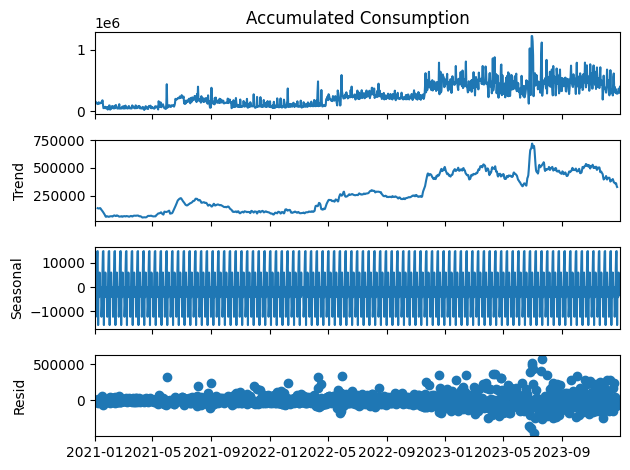

/Users/yuyi/Desktop/ProjectManagement/venv2/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yuyi/Desktop/ProjectManagement/venv2/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30267D+01    |proj g|=  6.81207D-02

At iterate    5    f=  1.29565D+01    |proj g|=  1.11582D-02

At iterate   10    f=  1.29547D+01    |proj g|=  3.64205D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     17      1     0     0   4.441D-06   1.295D+01
  F =   12.954706692930886     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                  

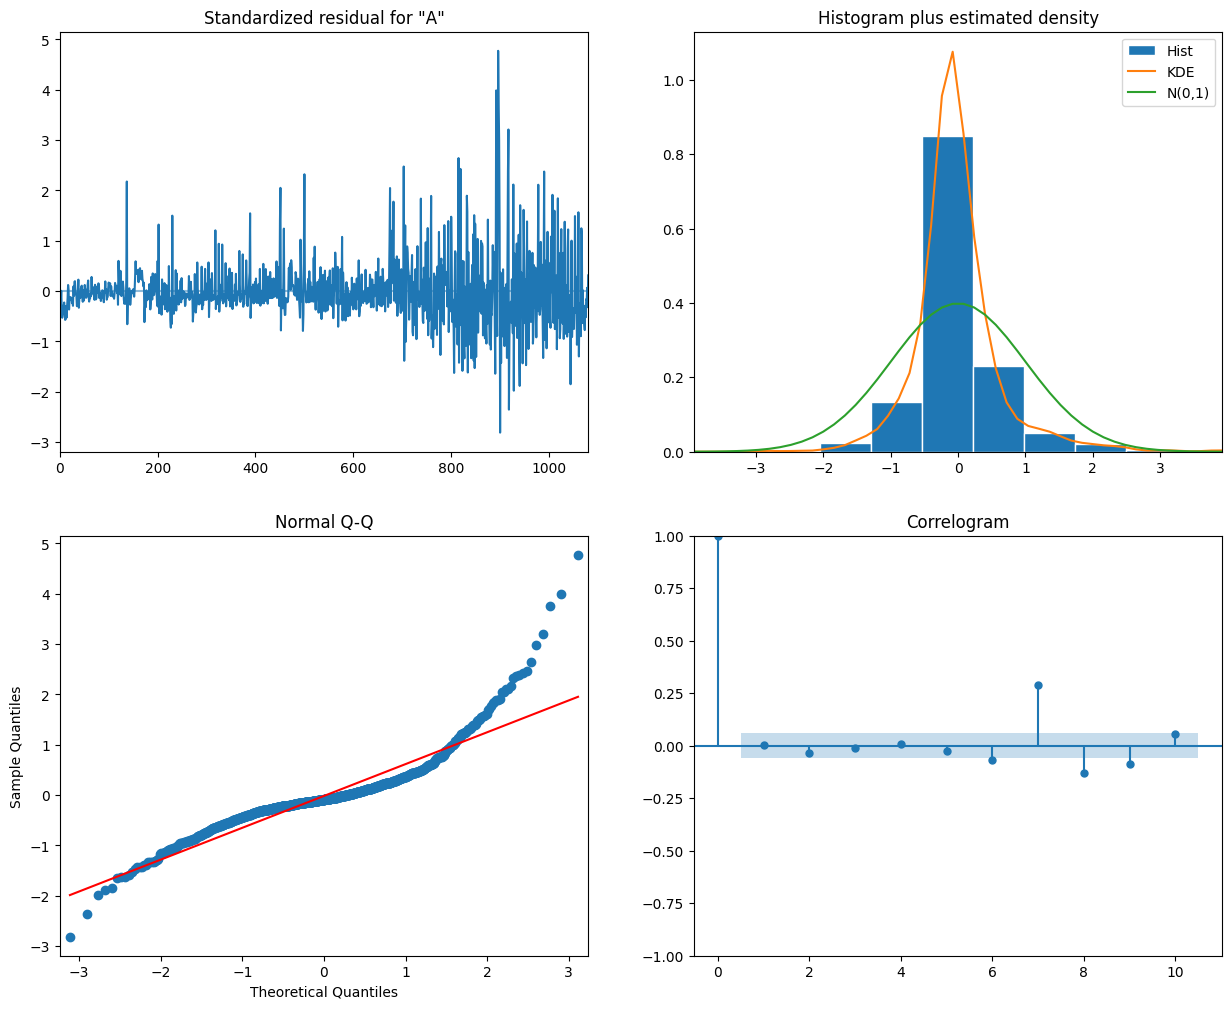

In [194]:
df_test = df_census[df_census["Census Section"]==801901001]

# Use time based indexing
df_test.set_index('Date', inplace=True)
# Removing an detected outlier
df_test = df_test.drop(pd.Timestamp('2022-03-09'))

# Check stationarity
result = adfuller(df_test['Accumulated Consumption'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# # TO IGNORE
# Technique used to make the time series stationary
if result[1] > 0.05:  # Data is not stationary
    df_test['Differenced Consumption'] = df_test['Accumulated Consumption'].diff().dropna()
    # raise Warning("There is no seasonality in the data")

# Seasonal Decompose
decompose_result = seasonal_decompose(df_test['Accumulated Consumption'], model='additive', period=12)
decompose_result.plot()
plt.show()

# SARIMA Model
# TODO: Explore more withthe order and the seasonal order
model = SARIMAX(df_test['Accumulated Consumption'], order=(1,1,1), seasonal_order=(1,1,1,12))
results = model.fit()

# Summarize the results
print(results.summary())

# Plot diagnostics
results.plot_diagnostics(figsize=(15, 12))
plt.show()

### Generalized Function

In [195]:
def sarima_census_section(census_section, df=df_census, outlier_date=None, seasonal_decomposition=False, diagnostic_plots=False):
    df_test = df[df["Census Section"] == census_section]
    df_test.set_index('Date', inplace=True)
    
    if outlier_date: df_test = df_test.drop(pd.Timestamp(outlier_date))
    
    # Check stationarity using the Augmented Dickey-Fuller test
    result = adfuller(df_test['Accumulated Consumption'])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    
    if result[1] > 0.05:
        print(f"There is no seasonality in the data for census {census_section}")
        df_test['Differenced Consumption'] = df_test['Accumulated Consumption'].diff().dropna()

    if seasonal_decomposition:
        decompose_result = seasonal_decompose(df_test['Accumulated Consumption'], model='additive', period=12)
        decompose_result.plot()
        plt.show()

    model = SARIMAX(df_test['Accumulated Consumption'], order=(1,1,1), seasonal_order=(1,1,1,12))
    results = model.fit()

    print(results.summary())

    if diagnostic_plots:
        results.plot_diagnostics(figsize=(15, 12))
        plt.show()

ADF Statistic: -5.055381
p-value: 0.000017


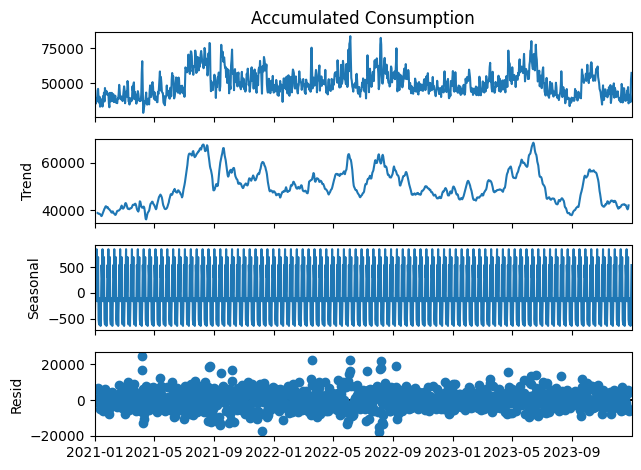

/Users/yuyi/Desktop/ProjectManagement/venv2/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/yuyi/Desktop/ProjectManagement/venv2/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00925D+01    |proj g|=  6.60912D-02

At iterate    5    f=  1.00518D+01    |proj g|=  8.08200D-03

At iterate   10    f=  1.00498D+01    |proj g|=  2.03665D-04

At iterate   15    f=  1.00498D+01    |proj g|=  6.44851D-05

At iterate   20    f=  1.00498D+01    |proj g|=  1.02031D-03

At iterate   25    f=  1.00483D+01    |proj g|=  1.52904D-02

At iterate   30    f=  9.96014D+00    |proj g|=  1.40789D-01

At iterate   35    f=  9.93372D+00    |proj g|=  8.90711D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

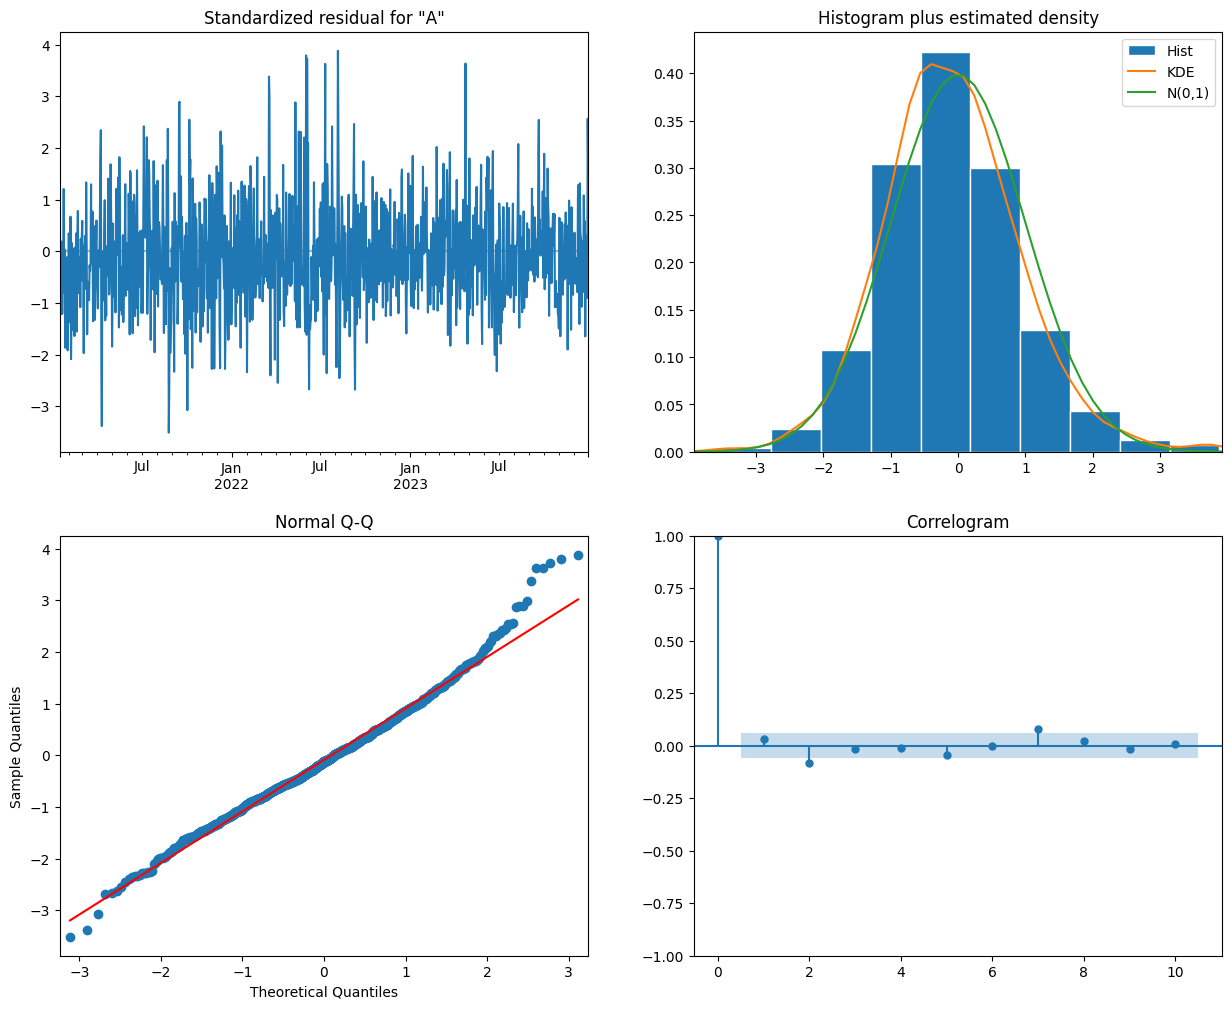

In [196]:
# Example having a better prediction but yet insufficient
sarima_census_section(801901002, seasonal_decomposition= True, diagnostic_plots=True)

## Vector Autoregression (VAR)

### Case Analysis Census Section \# 801901002

In [197]:
census_section = 801901002
df_test = df_census[df_census["Census Section"] == census_section]
var_columns = ['Accumulated Consumption', 'Tourist Accommodations', 'Max Temperature', 'Precipitation']
df_test = df_test[var_columns]

In [198]:
# Ensure stationarity
def check_stationarity(series, maxlag=None, regression='c', autolag='AIC'):
    result = adfuller(series, maxlag=maxlag, regression=regression, autolag=autolag)
    print(f'    ADF Statistic: {result[0]}')
    print(f'    p-value: {result[1]}')
    if result[1] > 0.05:
        print("     -> NOT stationary")
        return False
    else:
        print("     -> stationary")
        return True

In [199]:
# If many series are not stationary, consider applying transformations like differencing or detrending to the entire dataset or increasing the sample size for more robust testing.
for column in tqdm(df_test.columns, desc="Testing stationarity"):
    print(f"Testing stationarity for {column}:")
    if not check_stationarity(df_test[column]):
        df_test[column] = df_test[column].diff().dropna()  # Differencing non-stationary series

Testing stationarity: 100%|██████████| 4/4 [00:00<00:00, 96.97it/s]

Testing stationarity for Accumulated Consumption:
    ADF Statistic: -5.055380859354433
    p-value: 1.7223616995187117e-05
     -> stationary
Testing stationarity for Tourist Accommodations:
    ADF Statistic: -2.0532999443568807
    p-value: 0.2637025150716104
     -> NOT stationary
Testing stationarity for Max Temperature:
    ADF Statistic: -2.7108983606596153
    p-value: 0.07217128891048522
     -> NOT stationary
Testing stationarity for Precipitation:
    ADF Statistic: -21.306670560784738
    p-value: 0.0
     -> stationary


In [200]:
model = VAR(df_test.dropna())
var_test_model = model.fit(ic='aic')
print(var_test_model.summary())

# Save model to avoid repetitive fitting
if not os.path.exists('../models'): os.makedirs('../models')
with open(f'../models/var_model_{census_section}.pkl', 'wb') as f: pickle.dump(var_test_model, f)

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 21, Nov, 2024
Time:                     22:55:53
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    38.1089
Nobs:                     1080.00    HQIC:                   37.4550
Log likelihood:          -25912.4    FPE:                1.24063e+16
AIC:                      37.0566    Det(Omega_mle):     1.00994e+16
--------------------------------------------------------------------
Results for equation Accumulated Consumption
                                 coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------
const                            4734.927476      1227.954464            3.856           0.000
L1.Accumulated Consumption          0.664338         0.031420           21.144   

/Users/yuyi/Desktop/ProjectManagement/venv2/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [201]:
with open('../models/var_model_801901002.pkl', 'rb') as f:
    var_test_model = pickle.load(f)

In [202]:
# Forecasting
forecast_steps = 5
forecast = var_test_model.forecast(df_test.values[-var_test_model.k_ar:], steps=forecast_steps)
# df_census['Date'] = pd.to_datetime(df_census['Date'])
df_census.set_index('Date', inplace=True)
date_index = pd.date_range(start=df_census.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
forecast_df = pd.DataFrame(forecast, index=date_index, columns=df_test.columns)
print(forecast_df[['Accumulated Consumption', 'Tourist Accommodations']])

            Accumulated Consumption  Tourist Accommodations
2024-01-01             53134.052492           -11485.439147
2024-01-02             51527.345600              978.719990
2024-01-03             47982.150819             5998.603429
2024-01-04             45907.924834             1298.908393
2024-01-05             46528.680595             2402.979651


### Generalized Function

Limitations: 

* Depending on how the model has been formulated, it is predicting negative values on accumulated consumption; which in fact reveals that the model should be finetuned in some way or that it has to be formulated with some non negative constraints.

* The model can only take entries that are all time series, that is, all the variables should be time series.

* The model can be only trained with numerical values, hence it is not possible to put in the census section or the district as a feature. Moreover, it does not work well making encodings (such as dummy variables) to convert those categorical fields into booleans because they can only work when the date entry apprears only once in the set. Hence, a model for each census section should be trained separately based on their own historical data. However, it is feasible to adjust the granularity of these, either by working with districts or whatever division there can be. For instance, doing clustering and train a model for prediction for each cluster.

* Related to the previous point, the model works only with time-series data rather than handling data that is both cross-sectional and time-series.

In [203]:
def var_census_section(census_section, df=df_census, var_columns=['Accumulated Consumption', 'Tourist Accommodations', 'Max Temperature', 'Precipitation'], model_save_path='../models', save_model=True, ic='fpe', maxlag=None, regression='c', autolag='AIC', verbose=False):
    df_test = df[df["Census Section"] == census_section]
    df_test = df_test[var_columns]

    # Function to check stationarity
    def check_stationarity(series, name_column=None, verbose=False):
        result = adfuller(series, maxlag=maxlag, regression=regression, autolag=autolag)
        if verbose:
            print(f'{name_column} ADF Statistic: {result[0]}')
            print(f'{name_column} p-value: {result[1]}')
        if result[1] > 0.05:
            if verbose: print("-> {name_column} NOT stationary")
            return False
        else:
            if verbose: print("-> {name_column} stationary")
            return True

    # Ensure all columns are stationary
    for column in df_test.columns:
        if not check_stationarity(df_test[column], name_column=column):
            df_test[column] = df_test[column].diff().dropna()  # Differencing non-stationary series

    # Fit VAR model
    model = VAR(df_test.dropna())
    var_test_model = model.fit(ic=ic)
    if verbose: print(var_test_model.summary())

    if save_model:
        os.makedirs(model_save_path, exist_ok=True)
        model_file = os.path.join(model_save_path, f'var_model_{census_section}.pkl')
        with open(model_file, 'wb') as f:
            pickle.dump(var_test_model, f)
        if verbose: print(f"Model saved to {model_file}")

    return var_test_model, var_test_model.summary()

In [204]:
var_model_801901003, summary = var_census_section(census_section=801901003, verbose=True)

/Users/yuyi/Desktop/ProjectManagement/venv2/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 21, Nov, 2024
Time:                     22:55:53
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    38.6051
Nobs:                     1080.00    HQIC:                   37.9512
Log likelihood:          -26180.3    FPE:                2.03765e+16
AIC:                      37.5528    Det(Omega_mle):     1.65876e+16
--------------------------------------------------------------------
Results for equation Accumulated Consumption
                                 coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------
const                             438.365006       281.431881            1.558           0.119
L1.Accumulated Consumption         -0.519422         0.031483          -16.498   

In [205]:
def var_model_forecast(var_model, census_section, df=df_census, forecast_steps=5, columns_to_forecast=['Accumulated Consumption', 'Tourist Accommodations']):
    """
    Forecasts future values using a trained VAR model for the next days.

    :param var_model: Trained VAR model
    :param df: pd.DataFrame, the input dataframe used for training
    :param forecast_steps: int, number of steps to forecast
    :param columns_to_forecast: list, columns to include in the forecast output
    :return: pd.DataFrame, forecasted values with date index
    """
    df = df[df["Census Section"] == census_section]
    var_columns=['Accumulated Consumption', 'Tourist Accommodations', 'Max Temperature', 'Precipitation']
    df = df[var_columns]
    
    if not isinstance(df.index, pd.DatetimeIndex): raise ValueError("The DataFrame index must be a DatetimeIndex.")

    last_values = df.values[-var_model.k_ar:]
    forecast = var_model.forecast(last_values, steps=forecast_steps)

    # Create a DataFrame for the forecast
    forecast_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), 
                                   periods=forecast_steps, 
                                   freq='D')
    forecast_df = pd.DataFrame(forecast, index=forecast_dates, columns=df.columns)

    return forecast_df[columns_to_forecast]

In [206]:
var_model_forecast(var_model_801901003, census_section=801901003)

,Accumulated Consumption,Tourist Accommodations
2024-01-01,-235356.473204,-39227.319032
2024-01-02,-93442.646026,-25638.850989
2024-01-03,-31295.084240,-10605.579803
2024-01-04,-10472.843687,-3045.087347
2024-01-05,24967.652953,13771.942428


In [ ]:
class CensusSectionVAR(VAR):
    def __init__(self, df, census_section, var_columns, model_save_path='../models', verbose=False):
        """
        Initialize the CensusSectionVAR object.

        :param df: pd.DataFrame, the dataset containing census data
        :param census_section: int or str, the census section to filter on
        :param var_columns: list, the columns to use for the VAR model
        :param model_save_path: str, the directory to save the model
        :param verbose: bool, whether to print verbose output
        """
        self.df = df
        self.census_section = census_section
        self.var_columns = var_columns
        self.model_save_path = model_save_path
        self.verbose = verbose
        self.var_model = None

        # Filter data for the given census section and relevant columns
        self.df_test = self.df[self.df["Census Section"] == self.census_section][self.var_columns]
        if not isinstance(self.df_test.index, pd.DatetimeIndex):
            raise ValueError("The DataFrame index must be a DatetimeIndex.")

    def _check_stationarity(self, series, name_column=None, maxlag=None, regression='c', autolag='AIC'):
        """
        Check the stationarity of a time series using the Augmented Dickey-Fuller test.
        """
        result = adfuller(series, maxlag=maxlag, regression=regression, autolag=autolag)
        if self.verbose:
            print(f'{name_column} ADF Statistic: {result[0]}')
            print(f'{name_column} p-value: {result[1]}')
        if result[1] > 0.05:
            if self.verbose:
                print(f"-> {name_column} is NOT stationary")
            return False
        else:
            if self.verbose:
                print(f"-> {name_column} is stationary")
            return True

    def fit_model(self, ic='aic', maxlag=None, regression='c', autolag='AIC', save_model=True):
        """
        Fit the VAR model to the data.

        :param ic: str, the information criterion to use for lag selection
        :param maxlag: int or None, the maximum lag to consider
        :param regression: str, the regression type for ADF test
        :param autolag: str, the method to use for ADF lag selection
        :param save_model: bool, whether to save the fitted model
        :return: VAR model and its summary
        """
        # Ensure all columns are stationary
        for column in self.df_test.columns:
            if not self._check_stationarity(self.df_test[column], name_column=column, maxlag=maxlag, regression=regression, autolag=autolag):
                self.df_test[column] = self.df_test[column].diff().dropna()

        # Fit the VAR model
        model = VAR(self.df_test.dropna())
        self.var_model = model.fit(ic=ic)
        if self.verbose:
            print(self.var_model.summary())

        # Save the model
        if save_model:
            os.makedirs(self.model_save_path, exist_ok=True)
            model_file = os.path.join(self.model_save_path, f'var_model_{self.census_section}.pkl')
            with open(model_file, 'wb') as f:
                pickle.dump(self.var_model, f)
            if self.verbose:
                print(f"Model saved to {model_file}")

        return self.var_model

    def print_summary(self):
        if self.var_model is None:
            raise ValueError("No model is loaded or trained. Train a model or load one first.")
        print(self.var_model.summary())

    def forecast(self, forecast_steps, columns_to_forecast):
        """
        Forecast future values using the trained VAR model.

        :param forecast_steps: int, number of steps to forecast
        :param columns_to_forecast: list, columns to include in the forecast output
        :return: pd.DataFrame, forecasted values with date index
        """
        if self.var_model is None:
            raise ValueError("VAR model has not been trained. Call fit_model() first.")

        # Prepare the last values for forecasting
        last_values = self.df_test.values[-self.var_model.k_ar:]
        forecast = self.var_model.forecast(last_values, steps=forecast_steps)

        # Create a date range for the forecast
        forecast_dates = pd.date_range(start=self.df_test.index[-1] + pd.Timedelta(days=1),
                                       periods=forecast_steps,
                                       freq='D')

        # Create a DataFrame for the forecast
        forecast_df = pd.DataFrame(forecast, index=forecast_dates, columns=self.df_test.columns)
        return forecast_df[columns_to_forecast]
    
    @classmethod
    def load_model(cls, file_path, df, census_section, var_columns, model_save_path='../models', verbose=False):
        """
        Load a saved VAR model from a file.

        :param file_path: str, the path to the saved model file
        :param df: pd.DataFrame, the dataset for context (required for forecasting)
        :param census_section: int or str, the census section for context
        :param var_columns: list, the columns used in the VAR model
        :param model_save_path: str, directory for saving future models (if re-saving is needed)
        :param verbose: bool, whether to print verbose output
        :return: CensusSectionVAR object with loaded model
        """
        if not os.path.exists(file_path): raise FileNotFoundError(f"Model file not found at {file_path}")

        with open(file_path, 'rb') as f:
            var_model = pickle.load(f)
        
        # Initialize the object with context data
        obj = cls(df=df, census_section=census_section, var_columns=var_columns, model_save_path=model_save_path, verbose=verbose)
        obj.var_model = var_model

        if verbose: print(f"Model loaded from {file_path}")
        
        return obj

In [ ]:
# # Load model example
# loaded_instance = CensusSectionVAR.load_model(
#     file_path='../models/var_model_801901003.pkl',
#     df=df_census,
#     census_section=801901003,
#     var_columns=['Accumulated Consumption', 'Tourist Accommodations', 'Max Temperature', 'Precipitation'],
#     verbose=True
# )

Model loaded from ../models/var_model_801901003.pkl


In [214]:
# Example Usage
var_model = CensusSectionVAR(
    df=df_census,
    census_section=801901003,
    var_columns=['Accumulated Consumption', 'Tourist Accommodations', 'Max Temperature', 'Precipitation'],
    verbose=True
)

trained_model = var_model.fit_model(ic='fpe', save_model=True)

forecast_df = var_model.forecast(forecast_steps=5, columns_to_forecast=['Accumulated Consumption', 'Tourist Accommodations'])

print(forecast_df)

Accumulated Consumption ADF Statistic: -1.8233743811642804
Accumulated Consumption p-value: 0.3689202544430671
-> Accumulated Consumption is NOT stationary
Tourist Accommodations ADF Statistic: -2.0532999443568807
Tourist Accommodations p-value: 0.2637025150716104
-> Tourist Accommodations is NOT stationary
Max Temperature ADF Statistic: -2.7108983606596153
Max Temperature p-value: 0.07217128891048522
-> Max Temperature is NOT stationary
Precipitation ADF Statistic: -21.306670560784738
Precipitation p-value: 0.0
-> Precipitation is stationary
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 21, Nov, 2024
Time:                     23:00:45
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    38.6051
Nobs:                     1080.00    HQIC:                   37.9512
Log likelihood:          -26180.3    FPE:                2.03765e+16


/Users/yuyi/Desktop/ProjectManagement/venv2/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


## Hierarchical Time Series Modeling

Powerful approach when data naturally forms a hierarchy; allows to forecast at various levels of aggregation, ensuring that forecasts at lower levels aggregate up consistently to higher levels, which can enhance the coherence and accuracy across forecasts.

In [ ]:
df_hierarchy['District'] = df_hierarchy['District'].astype(str)
df_hierarchy['Census Section'] = df_hierarchy['Census Section'].astype(str)
df_hierarchy['Date'] = pd.to_datetime(df_hierarchy['Date'])
df_hierarchy.set_index('Date', inplace=True)
df_hierarchy.sort_index(inplace=True)

In [ ]:
# Define hierarchy
hierarchy = {
    'Total': df_hierarchy['District'].unique().tolist(),
}

for district in hierarchy['Total']:
    hierarchy[district] = df_hierarchy[df_hierarchy['District'] == district]['Census Section'].unique().tolist()

In [ ]:
print(hierarchy)

{'Total': ['1', '2', '6', '10', '3', '5', '7', '4', '8', '9'], '1': ['801901001', '801901043', '801901027', '801901044', '801901002', '801901032', '801901005', '801901017', '801901042', '801901010', '801901046', '801901009', '801901031', '801901047', '801901014', '801901022', '801901006', '801901018', '801901045', '801901023', '801901016', '801901025', '801901011', '801901038', '801901036', '801901003', '801901037', '801901035', '801901026', '801901040', '801901033', '801901041', '801901039', '801901004', '801901012', '801901034', '801901015', '801901008', '801901028', '801901013', '801901049', '801901051', '801901052', '801901053', '801901054', '801901020', '801901048', '801901050', '801901021', '801901030', '801901019', '801901029', '801901055', '801901007'], '2': ['801902027', '801902059', '801902074', '801902161', '801902115', '801902127', '801902094', '801902147', '801902093', '801902075', '801902128', '801902040', '801902003', '801902114', '801902013', '801902146', '801902041', '

In [ ]:
# Pivot the table to get Districts and Census Sections as column levels
df_agg = df_hierarchy.pivot_table(index=['Date'], 
                            columns=['District', 'Census Section'],
                            values=['Accumulated Consumption', 'Number of Meters', 'Max Temperature', 
                                    'Min Temperature', 'Precipitation', 'Tourist Accommodations', 'Hotel Overnight Stays'])

# Fill NaN with zero if that makes sense for your analysis
df_agg.fillna(0, inplace=True)

# Sum across all columns to get a total for each date, assuming this is what you want in the 'Total' column
df_agg['Total'] = df_agg.sum(axis=1)

In [ ]:
df_agg.head()

Accumulated Consumption                                \
District                             1                                 
Census Section               801901001 801901002 801901003 801901004   
Date                                                                   
2021-01-01                    153414.0   37473.0   22264.0   33074.0   
2021-01-02                    166201.0   40064.0   21997.0   44716.0   
2021-01-03                    129309.0   35311.0   23051.0   50009.0   
2021-01-04                    141909.0   39283.0   25398.0   46823.0   
2021-01-05                    137782.0   36689.0   32732.0   40161.0   

                                                                            \
District                                                                     
Census Section 801901005 801901006 801901007 801901008 801901009 801901010   
Date                                                                         
2021-01-01       63850.0   40154.0   48386.0   27994.0   15465.0   28209.0   
2021-01-02       95572.0   33717.0   37311.0   27936.0   20672.0   27030.0   
2021-01-03       72636.0   32651.0   32236.0   28911.0   22804.0   28320.0   
2021-01-04       88006.0   33944.0   39058.0   39577.0   17899.0   27248.0   
2021-01-05       81198.0   31948.0   41488.0   36984.0   17169.0   26444.0   

                ... Tourist Accommodations                                \
District        ...                      9                                 
Census Section  ...              801909088 801909089 801909090 801909091   
Date            ...                                                        
2021-01-01      ...                    0.0       0.0       0.0       0.0   
2021-01-02      ...                    0.0       0.0       0.0       0.0   
2021-01-03      ...                    0.0       0.0       0.0       0.0   
2021-01-04      ...                    0.0       0.0       0.0       0.0   
2021-01-05      ...                    0.0       0.0       0.0       0.0   

                                                                         Total  
District                                                                        
Census Section 801909092 801909093 801909094 801909095 801909156                
Date                                                                            
2021-01-01           0.0       0.0    1775.0       0.0       0.0  2.420680e+07  
2021-01-02           0.0       0.0    4646.0       0.0       0.0  3.467993e+07  
2021-01-03           0.0       0.0    3151.0       0.0       0.0  2.990599e+07  
2021-01-04           0.0       0.0    4337.0       0.0       0.0  3.741379e+07  
2021-01-05           0.0       0.0    4580.0       0.0       0.0  3.771379e+07  

[5 rows x 7519 columns]

In [ ]:
print(df_agg.head())
print(df_agg.columns)

               Accumulated Consumption                                \
District                             1                                 
Census Section               801901001 801901002 801901003 801901004   
Date                                                                   
2021-01-01                    153414.0   37473.0   22264.0   33074.0   
2021-01-02                    166201.0   40064.0   21997.0   44716.0   
2021-01-03                    129309.0   35311.0   23051.0   50009.0   
2021-01-04                    141909.0   39283.0   25398.0   46823.0   
2021-01-05                    137782.0   36689.0   32732.0   40161.0   

                                                                            \
District                                                                     
Census Section 801901005 801901006 801901007 801901008 801901009 801901010   
Date                                                                         
2021-01-01       63850.0   40154.0   48

In [ ]:
from hts import HTSRegressor

# Initialize the HTS model
model = HTSRegressor(model='auto_arima', revision_method='OLS', root='Total', n_jobs=0)

# Fit the model to the aggregated data
model.fit(df_agg, hierarchy)

KeyError: "['total'] not in index"